# Ataque físico a detección de matricula Española modelo WPOD NET
Este notebook ejecuta un ataque fisico (adversarial attack) al modelo WPOD NET
La imagen utilizada posee un pequeño parche en la matricula que hace interpretar los números "1" como "3"

## Procesamiento imagen original

In [1]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "" 

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob
import tensorflow as tf

Using TensorFlow backend.


In [2]:
"""
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
"""

'\ngpus = tf.config.experimental.list_physical_devices(\'GPU\')\nif gpus:\n  try:\n    # Currently, memory growth needs to be the same across GPUs\n    for gpu in gpus:\n      tf.config.experimental.set_memory_growth(gpu, True)\n    logical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\n    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")\n  except RuntimeError as e:\n    # Memory growth must be set before GPUs have been initialized\n    print(e)\n'

### funciones

In [17]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)


def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor


# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    #resultado = np.argmax(model.predict(image[np.newaxis,:]))
    resultado = model.predict(image[np.newaxis,:])
    return prediction, resultado

# Función que entrega la etiqueta y probabilidad -> decode de respuesta
def get_imagenet_label(probs):
  result = np.where(probs[0] == np.amax(probs[0]))
  max_index = result[0][0]
  probabilidad=probs[0][max_index]
  label = fashion_mnist_labels[max_index] 
  #return  str(label) + " con probabilidad: " + str(probabilidad)
  return  "",label, probabilidad

def display_images(image, description, model):
  #_, label, confidence = get_imagenet_label(model_01.predict(image))
  _, label, confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  #plt.imshow(image[0])
  plt.imshow(np.squeeze(image[0]))
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

In [18]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


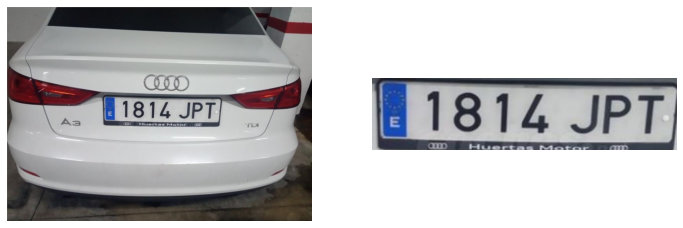

In [19]:



test_image_path = "../img/española/ae_esp/original_esp.jpg" #"../img/española/ae_esp/original_esp.jpg" #"../img/española/ae67.jpg"#"../img/española/ae48.jpg" #"../img/española/ae16.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

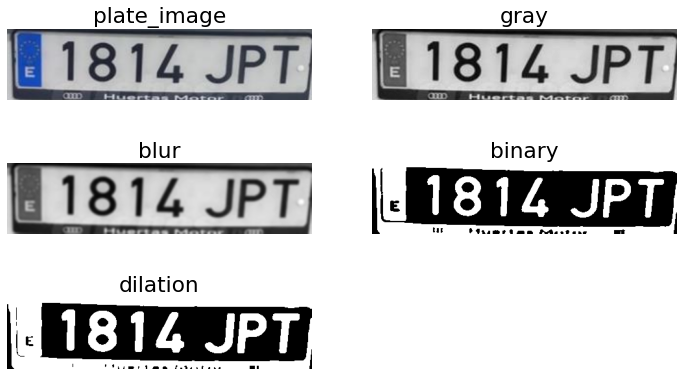

In [20]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

# plt.savefig("threshding.png", dpi=300)

Detect 7 letters...


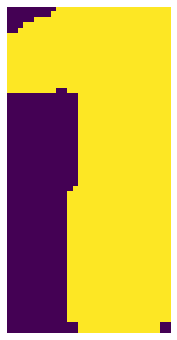

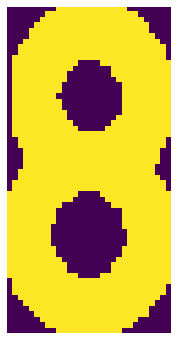

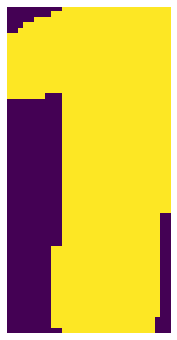

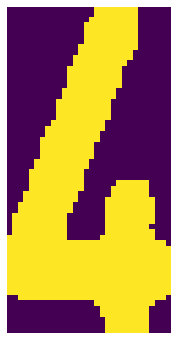

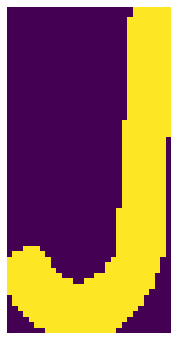

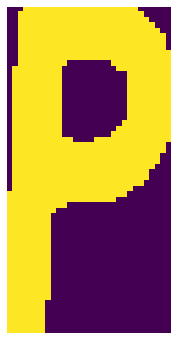

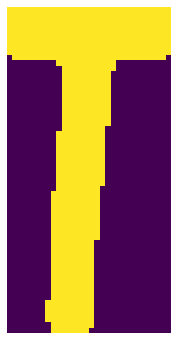

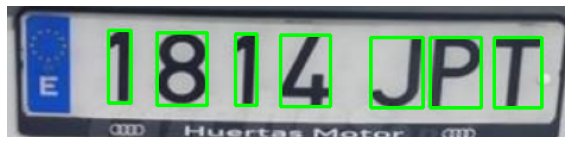

In [21]:


cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            """
            fig = plt.figure(figsize=(6,6))
            plt.axis(False)
            plt.imshow(curr_num)
            """
            
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            fig = plt.figure(figsize=(6,6))
            plt.axis(False)
            plt.imshow(curr_num)
            
            crop_characters.append(curr_num)
            
            

print("Detect {} letters...".format(len(crop_characters)))
#fig = plt.figure(figsize=(10,6))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.imshow(fig)
plt.savefig('grab_digit_contour.png',dpi=300)

(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)


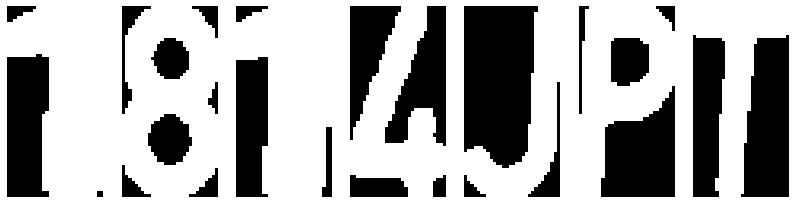

In [22]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
    print(crop_characters[i].shape)
    
#plt.savefig("segmented_leter.png",dpi=300)    

In [23]:
# Load model architecture, weight and labels


json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

[INFO] Model loaded successfully...


In [24]:
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Labels loaded successfully...


---------------
clase: 1
index: 1
prob: 0.98868644
---------------
clase: 8
index: 8
prob: 0.9999976
---------------
clase: 1
index: 1
prob: 0.9999815
---------------
clase: 4
index: 4
prob: 1.0
---------------
clase: J
index: 19
prob: 0.99997747
---------------
clase: P
index: 25
prob: 1.0
---------------
clase: T
index: 29
prob: 0.9999988
Achieved result:  1814JPT


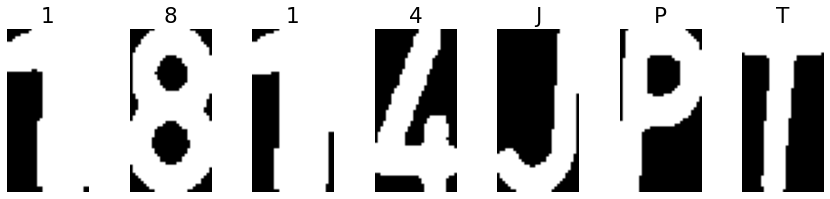

In [25]:


fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    prediction, resultado = predict_from_model(character,model,labels)
    title = np.array2string(prediction)
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')
    print("---------------")
    #print("resultado:  " + str(resultado))
    print("clase: " + title.strip("'[]"))
    print("index: " + str(np.argmax(resultado)))
    print("prob: " + str(resultado[0,np.argmax(resultado)]))
    

print("Achieved result: ", final_string)
#plt.savefig('final_result.png', dpi=300)

## Procesamiento Adversarial Atack

In [36]:
adversarial_examples = [
"../img/española/ae_esp/ae1.jpg",
"../img/española/ae_esp/ae2.jpg",
"../img/española/ae_esp/ae3.jpg",
"../img/española/ae_esp/ae4.jpg",
"../img/española/ae_esp/ae5.jpg",
"../img/española/ae_esp/ae6.jpg",
"../img/española/ae_esp/ae7.jpg",
"../img/española/ae_esp/ae8.jpg",
"../img/española/ae_esp/ae9.jpg",
"../img/española/ae_esp/ae10.jpg",
"../img/española/ae_esp/ae11.jpg",
"../img/española/ae_esp/ae12.jpg",
"../img/española/ae_esp/ae13.jpg",
"../img/española/ae_esp/ae14.jpg",
"../img/española/ae_esp/ae15.jpg",
"../img/española/ae_esp/ae16.jpg",
"../img/española/ae_esp/ae17.jpg",
"../img/española/ae_esp/ae18.jpg",
"../img/española/ae_esp/ae19.jpg",
"../img/española/ae_esp/ae20.jpg",
"../img/española/ae_esp/ae21.jpg",
"../img/española/ae_esp/ae22.jpg",
"../img/española/ae_esp/ae23.jpg",
"../img/española/ae_esp/ae24.jpg",
"../img/española/ae_esp/ae25.jpg"
]

/home/rodrigo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


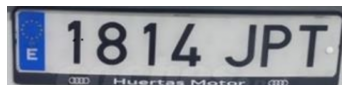

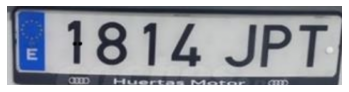

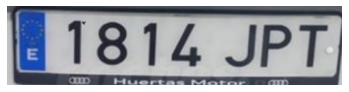

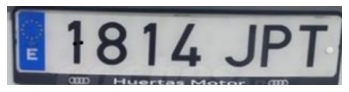

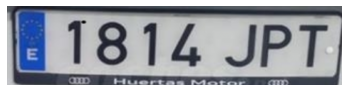

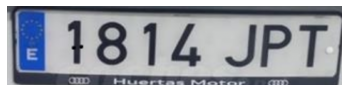

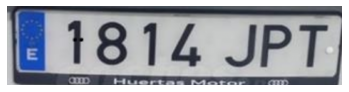

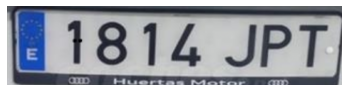

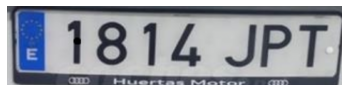

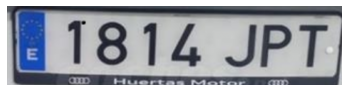

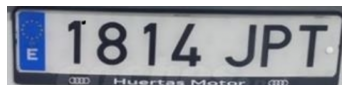

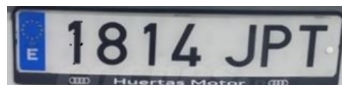

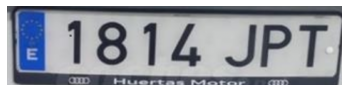

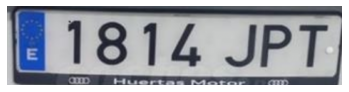

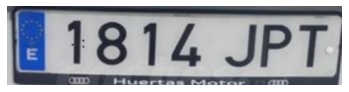

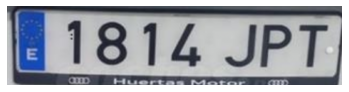

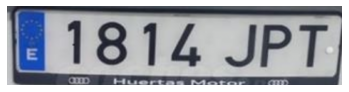

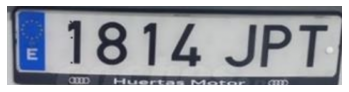

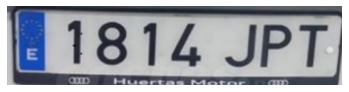

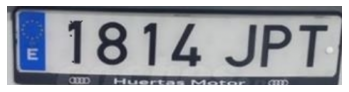

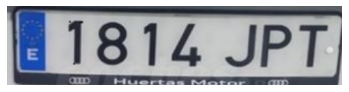

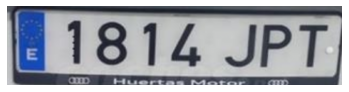

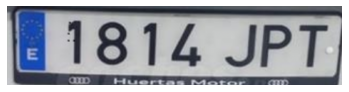

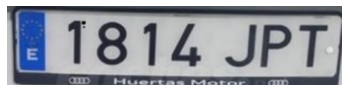

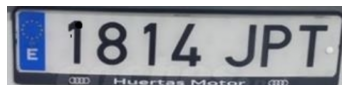

In [38]:
for i,ae in enumerate(adversarial_examples):
    #tf.keras.backend.clear_session()
    #print(ae)
    test_image_path = ae #fisico01.jpg"
    vehicle, LpImg,cor = get_plate(test_image_path)

    fig = plt.figure(figsize=(6,3))
    plt.axis(False)
    plt.imshow(LpImg[0])

In [37]:
# Load model architecture, weight and labels
import tensorflow as tf

json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")

from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
    
for p,ae in enumerate(adversarial_examples):
    test_image_path = ae
    vehicle, LpImg,cor = get_plate(test_image_path)
    if (len(LpImg)): #check if there is at least one license image
        # Scales, calculates absolute values, and converts the result to 8-bit.
        plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

        # convert to grayscale and blur the image
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(7,7),0)

        # Applied inversed thresh_binary 
        binary = cv2.threshold(blur, 180, 255,
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
        ###
        
    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = plate_image.copy()

    # Initialize a list which will be used to append charater image
    crop_characters = []

    # define standard width and height of character
    digit_w, digit_h = 30, 60

    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 1<=ratio<=3.5: # Only select contour with defined ratio
            if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
                # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                # Sperate number and gibe prediction
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))        
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)                    
                crop_characters.append(curr_num)


    final_string = ''
    for i,character in enumerate(crop_characters):
        fig.add_subplot(grid[i])
        prediction, resultado = predict_from_model(character,model,labels)
        title = np.array2string(prediction)
        final_string+=title.strip("'[]")


    if final_string == "1814JPT":
        print("imagen nº:" + str(p+1) +" ,Achieved result: ", final_string + ", resultado correcto")
    else:
        print("imagen nº:" + str(p+1) +" ,Achieved result: ", final_string + ", Fallo en Clasificador!")
       

/home/rodrigo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


imagen nº:1 ,Achieved result:  1814JPT, resultado correcto
imagen nº:2 ,Achieved result:  1814JPT, resultado correcto
imagen nº:3 ,Achieved result:  T814JPT, Fallo en Clasificador!
imagen nº:4 ,Achieved result:  1814JPT, resultado correcto
imagen nº:5 ,Achieved result:  T814JPT, Fallo en Clasificador!
imagen nº:6 ,Achieved result:  1814JPT, resultado correcto
imagen nº:7 ,Achieved result:  1814JPT, resultado correcto
imagen nº:8 ,Achieved result:  1814JPT, resultado correcto
imagen nº:9 ,Achieved result:  1814JPT, resultado correcto
imagen nº:10 ,Achieved result:  T814JPT, Fallo en Clasificador!
imagen nº:11 ,Achieved result:  T814JPT, Fallo en Clasificador!
imagen nº:12 ,Achieved result:  1814JPT, resultado correcto
imagen nº:13 ,Achieved result:  1814JPT, resultado correcto
imagen nº:14 ,Achieved result:  1814JPT, resultado correcto
imagen nº:15 ,Achieved result:  1814JPT, resultado correcto
imagen nº:16 ,Achieved result:  1814JPT, resultado correcto
imagen nº:17 ,Achieved result:  1

# Happy Hacking!